In [9]:
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')
import pandas as pd, os, json, numpy as np, re, textacy, pickle, string, re, nltk,  spacy, flashtext, contractions, unicodedata
from datetime import datetime; from dateutil import parser; 
from collections import Counter; from pprint import pprint
import textacy; from textacy import preprocessing, ke, vsm, tm, text_utils, Corpus, doc
from cytoolz import itertoolz
import joblib; from tabulate import tabulate; from time import time
from flashtext import KeywordProcessor
from urllib.parse import urlparse

from gensim.models.wrappers import LdaMallet; from gensim.models import LdaModel, LsiModel,  HdpModel, CoherenceModel
import gensim; from gensim.corpora import Dictionary;  from gensim import corpora

import sklearn;from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation,  TruncatedSVD
from sklearn.model_selection import GridSearchCV
from pprint import pprint

from IPython.display import display
import seaborn as sns, matplotlib.pyplot as plt, matplotlib.image as mpimg, base64, io, os,  matplotlib.colors as mcolors
%matplotlib inline
sns.set()  # defines the style of the plots 
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as patches
from wordcloud import WordCloud, STOPWORDS

from sklearn.manifold import TSNE
import bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

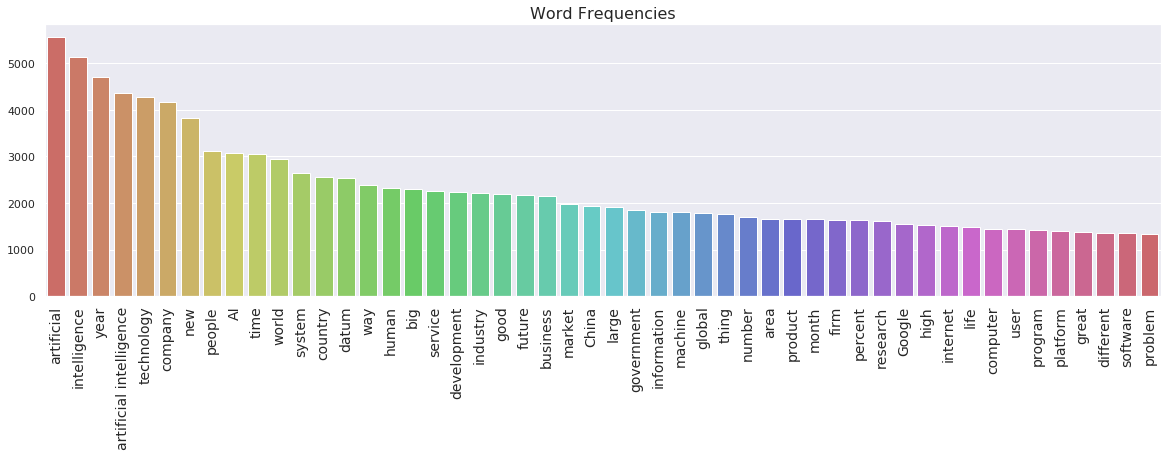

In [10]:
with open ('yak_vector', 'rb') as fp:# posrank terms
    terms = pickle.load(fp)#prnk yakws100 scak yak10 sr bot yak10

terms= [[i[0] for i in li] for li in terms]#for example prnk

############################this is for the tokenized sgr#############################################
terms_dict = Counter(np.concatenate(terms))#count words
terms_df = pd.DataFrame.from_dict(terms_dict, orient='index')#dict to dataframe
terms_df.rename(columns={0: 'count'}, inplace=True)#chnage the name of column
terms_df.sort_values('count', ascending=False, inplace=True)#sort

def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(terms_df)#changew raw
ax.set_title("Word Frequencies", fontsize=16);

# 1. This part cleans trims the dictionary from extreme values and looks again


In [11]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['people', 'subject', 'p.m.', 'early', 'time', 'year', 'use', 'not', 'would', 'say', 'could',  'be', 'know', 
                   'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see',
                   'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right',
                   'line', 'even', 'also', 'may', 'take', 'come' ,  'able',  'area','case',  'company','country',
                   'day','decade','example','future','head','high','January','lot','month','need','number','number',
                   'people','percent','place','result','thing','time','Tuesday','use','way','week',   'world','year',
                   'artificial intelligence', 'artificial intelligence AI', 'A.I.','ai' ,'April', 'August', 'century',
                   'date', 'December', 'difficult', 'dozen', 'February','form','great','history','hour','hundred',
                  'July','June','kilometer','kind','late','long','March','million','million','minute',
                   'November','October','part','past','point','previous', 'real','recent',
                   'role','September','term','thousand','today', 'January', 'May', 'Monday', 'Wednesday',
                  'Thursday', 'Friday', 'Saturday', 'Sunday', 'ush','ush(function', 'IST', 'ist' ])

from spacy.lang.en.stop_words import STOP_WORDS
stop_words =  set(stop_words).union(set(STOP_WORDS))

lms = [[word.lower() for word in doc if word not in stop_words] for doc in terms]     

abo=.95# for terms = .90, prnk. yak =.95 yak300 .95
belo=25# for tersm =25   yak =15, tr, prnk,sgrnk =10 yak 300 25
dictionary = Dictionary(documents=lms)
print("Found {} words.".format(len(dictionary.values())))
dictionary.filter_extremes(no_above=abo, no_below=belo)
dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

#dictionary.save('dictionary')
corpus = [dictionary.doc2bow(text) for text in lms]
#corpora.MmCorpus.serialize('corpus.mm', corpus)  # save corpus to disk
from gensim import matutils
data_dense =gensim.matutils.corpus2dense(corpus, len(dictionary.values()) )
# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Found 355971 words.
Left with 5977 words.
Sparsicity:  1.835290539993037 %


parameter selection:  Adopting the uniform Dirichlet priors
suggested by Steyvers and Griffiths (2007) (alpha=50/T = 6.25; beta = 0.01 for 2 <= T <= 10),

The fixed unit of 120 words, originally preferred by Osgood et al. (1957)
in the early days of computer-assisted content analysis, may, however, still be found to
produce stable, interpretable representations of conceptual relationships at a

In [12]:
#hdp

hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
CoherenceModel(model=hdpmodel, texts=lms, dictionary=dictionary, coherence='c_v').get_coherence()

#to choose the opt number of topics check the weights set up a threshold (i.e 01)
def topic_prob_extractor(hdpmodel):
    shown_topics = hdpmodel.show_topics(num_topics=100, formatted=False)
    topics_nos = [x[0] for x in shown_topics ]
    weights = [ sum([item[1] for item in shown_topics[topicN][1]]) for topicN in topics_nos ]

    return pd.DataFrame({'topic_id' : topics_nos, 'weight' : weights})

topic_prob_extractor(hdpmodel)

0.5187502556472559

,topic_id,weight
0,0,0.068327
1,1,0.068928
2,2,0.059987
3,3,0.043185
4,4,0.040010
...,...,...
95,95,0.021301
96,96,0.022307
97,97,0.020327
98,98,0.021272


In [13]:
hdpmodel.show_topics(num_topics=60, formatted=False)[0:60]

[(0,
  [('artificial', 0.006763470802818363),
   ('intelligence', 0.006283780351887554),
   ('technology', 0.005570438714524507),
   ('new', 0.005061797489165494),
   ('ai', 0.0034002168621185508),
   ('business', 0.0033980528312256226),
   ('industry', 0.0033324237381253986),
   ('datum', 0.003168374108308305),
   ('system', 0.003060131675854862),
   ('service', 0.0030250033424329237),
   ('development', 0.0029023474628867662),
   ('big', 0.0028963615290277804),
   ('market', 0.0026866085661236294),
   ('global', 0.0026253337582240444),
   ('research', 0.0025368664581403625),
   ('information', 0.0025330612204660197),
   ('large', 0.00237033872240005),
   ('human', 0.002297086457056584),
   ('product', 0.0022271698054226663),
   ('government', 0.0021883465754229414)]),
 (1,
  [('artificial', 0.007100123644188222),
   ('intelligence', 0.006637543411856483),
   ('technology', 0.005563283522805484),
   ('new', 0.004974875024290713),
   ('ai', 0.003814614129933128),
   ('development', 0.0

# Select the best model

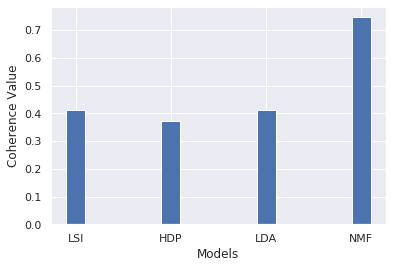

In [14]:
ntl=100
lsimodel = LsiModel(corpus=corpus, num_topics=ntl, id2word=dictionary)
ldamodel = LsiModel(corpus=corpus, num_topics=ntl, id2word=dictionary)
#mallet = LdaMallet(mallet_path, id2word=dictionary, num_topics=ntl, corpus=corpus)
#LDMallet = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet)
##########NMF############################
vectorizer = vsm.Vectorizer(tf_type="linear", apply_idf=True, idf_type="smooth", norm="l2",\
                                min_df=belo, max_df=abo)#tfidf
doc_term_matrix =vectorizer.fit_transform(lms)

nmfmodel = NMF( init="nndsvd", n_components=ntl ) 
doc_topic_matrix = nmfmodel.fit_transform( doc_term_matrix )#
H = nmfmodel.components_ # term weights relative to each of the k topics.
#to which topic is related the word
terms=vectorizer.terms_list
#############################################

lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]
hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]
#maltopics = [[word for word, prob in topic] for topicid, topic in LDMallet.show_topics(num_topics=ntl, formatted=False)]
#######GET TOPICS with KWs for NMF######################################

def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

nmftopics = []#descriptors is the other name
for topic_index in range(ntl):#10 is the no of topic words, as with the other models=10
    nmftopics.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( nmftopics[topic_index] )
 ##########################################################################   

lsi_coherence = CoherenceModel(topics=lsitopics, texts=lms, dictionary=dictionary, window_size=200).get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics, texts=lms, dictionary=dictionary, window_size=200).get_coherence()
lda_coherence = CoherenceModel(topics=ldatopics, texts=lms, dictionary=dictionary, window_size=200).get_coherence()
#mallet_coherence = CoherenceModel(topics=maltopics, texts=lms, dictionary=dictionary, window_size=200).get_coherence()
nmf_coherence = CoherenceModel(topics=nmftopics, texts=lms, dictionary=dictionary, window_size=200).get_coherence()

def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence, nmf_coherence],
                   ['LSI', 'HDP', 'LDA', 'NMF'])

# Gensim Models

In [15]:
########################GENSIM MODELS#############################
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = LdaMallet(mallet_path, id2word=dictionary, corpus=corpus, num_topics=num_topics)
        #HdpModel(corpus=corpus, id2word=dictionary)
        #LdaMallet(mallet_path, id2word=dictionary, corpus=corpus,iterations=30 , num_topics=num_topics)
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        #LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        topics = [[word for word, prob in topic] for topicid, topic in model.show_topics(num_topics=num_topics, formatted=False)]
        coherencemodel = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v',window_size=200)
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

lmt=100; strt=10; stp=10

model_list, coherence_values = compute_coherence_values(dictionary, corpus=corpus, texts=lms, start=strt, limit=lmt, step=stp)

Show Graph

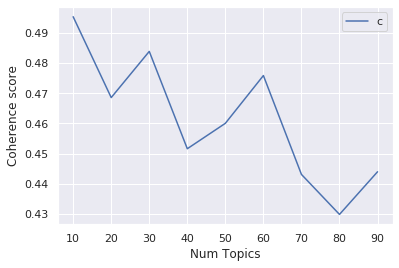

In [16]:
x = range(strt, lmt, stp)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show();

.55 is okay

.65 might be as good as it is going to get

.7 is nice


# Select the model and print the topics

In [17]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10,num_topics=40))

[(0,
  '0.008*"artificial" + 0.007*"intelligence" + 0.007*"new" + '
  '0.007*"technology" + 0.005*"ai" + 0.005*"research" + 0.004*"human" + '
  '0.004*"university" + 0.004*"science" + 0.004*"earth"'),
 (1,
  '0.013*"national university" + 0.012*"culinary" + 0.009*"seoul national '
  'university" + 0.008*"seoul national" + 0.008*"cho" + 0.007*"artificial" + '
  '0.006*"amateur" + 0.006*"intelligence" + 0.005*"mixture" + 0.005*"ai"'),
 (2,
  '0.010*"seoul" + 0.009*"korea" + 0.008*"artificial" + 0.008*"intelligence" + '
  '0.007*"technology" + 0.006*"service" + 0.006*"lee" + 0.005*"new" + '
  '0.005*"president recep tayyip" + 0.005*"istanbul"'),
 (3,
  '0.007*"artificial" + 0.007*"new" + 0.007*"intelligence" + '
  '0.006*"technology" + 0.005*"home" + 0.004*"ai" + 0.004*"product" + '
  '0.004*"menu" + 0.004*"market" + 0.003*"copyright"'),
 (4,
  '0.009*"artificial" + 0.008*"central news agency" + 0.008*"intelligence" + '
  '0.007*"new" + 0.006*"technology" + 0.006*"function" + 0.005*"produ

**LDA parameters :**
Assuming symmetric Dirichlet distributions, a low alpha value places more weight on having each document composed of only a few dominant topics (whereas a high value will return many more relatively dominant topics). Similarly, a low beta value places more weight on having each topic composed of only a few dominant words.
Also, an asymmetric alpha is helpful, where as an asymmetric beta is largely not.
Gensim: ’asymmetric’: Uses a fixed normalized asymmetric prior of 1.0 / topicno.
’auto’: Learns an asymmetric prior from the corpus, or you can 1D array of length equal to the number of expected topics that expresses our a-priori belief for the each topics’ probability. 

In [18]:
ntp=60
LDModel = LdaModel(corpus=corpus, num_topics=ntp, id2word=dictionary)
#mallet = LdaMallet(mallet_path, id2word=dictionary, num_topics=ntp, corpus=corpus)
#LDMallet = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet)

In [19]:
#cm = CoherenceModel(model=LDMallet,topn=ntp, corpus=corpus, texts=lms, dictionary=dictionary, coherence='c_v',window_size=200)
#cm.get_coherence()  # get coherence value

In [20]:
#start HERE
#LDMallet.save('LDMallet')
#LDMallet =  LdaModel.load('LDMallet')

In [21]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    return terms

topic_kws= []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(ntp):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(LDModel,topic_number=i, topn=10, output=True )
#     print tmp[:5]
    topic_kws += [tmp[:5]]
    print

term                 frequency

Topic 0 |---------------------

tooth                0.019
multimedia           0.017
variant              0.013
color                0.008
chore                0.008
three_year           0.007
artificial intelligence algorithm 0.007
intelligence algorithm 0.007
artificial           0.007
ai engine            0.006


<function print>

Topic 1 |---------------------

robot                0.011
human                0.010
question             0.009
artificial           0.008
intelligence         0.008
musk                 0.008
elon                 0.007
humanity             0.007
elon musk            0.007
hawking              0.007


<function print>

Topic 2 |---------------------

ice cream            0.009
pub                  0.007
new                  0.006
artificial           0.005
bread                0.005
cream                0.005
dutch                0.004
human                0.004
technology           0.003
new york             0.003


<function print>

Topic 3 |---------------------

military             0.016
defense              0.013
weapon               0.012
drone                0.008
intelligence         0.008
artificial           0.008
missile              0.007
system               0.007
autonomous           0.006
sputnik              0.006


<function print>

Topic 4 |---------------------

technology           0.008
artificial           0.008
intelligence         0.007
new                  0.006
president            0.005
china                0.005
business             0.005
chinese              0.005
global               0.005
research             0.005


<function print>

Topic 5 |---------------------

intelligence         0.008
artificial           0.007
new                  0.005
system               0.005
technology           0.005
delhi                0.004
game                 0.004
software             0.003
ward                 0.003
reality              0.003


<function print>

Topic 6 |---------------------

intelligence         0.009
artificial           0.008
mobile carrier       0.008
kt                   0.007
new                  0.006
datum                0.005
technology           0.005
mobile               0.005
user                 0.005
fifth_generation     0.004


<function print>

Topic 7 |---------------------

orbit                0.014
spacecraft           0.011
mars                 0.010
earth                0.009
nasa                 0.008
dragon               0.008
mission              0.007
intelligence         0.007
musk                 0.006
co_founded           0.006


<function print>

Topic 8 |---------------------

artificial           0.008
intelligence         0.007
electric             0.006
whatsapp             0.006
new                  0.006
technology           0.005
facebook             0.005
development center   0.005
electric vehicle     0.004
twitter              0.004


<function print>

Topic 9 |---------------------

court                0.008
intelligence         0.006
minister             0.005
artificial           0.005
government           0.005
official             0.005
security             0.005
international        0.004
report               0.004
party                0.004


<function print>

Topic 10 |---------------------

patient              0.014
medical              0.012
treatment            0.010
doctor               0.010
disease              0.009
health               0.009
artificial           0.008
intelligence         0.008
system               0.007
clinical             0.007


<function print>

Topic 11 |---------------------

story                0.006
new                  0.006
artificial           0.005
life                 0.004
intelligence         0.004
japan                0.004
little               0.004
young                0.004
social               0.004
woman                0.004


<function print>

Topic 12 |---------------------

technology           0.008
intelligence         0.008
artificial           0.007
new                  0.007
system               0.005
ai                   0.005
keyword              0.005
machine              0.005
datum                0.004
copyright            0.004


<function print>

Topic 13 |---------------------

artificial           0.008
intelligence         0.008
technology           0.007
development          0.006
industry             0.005
new                  0.005
global               0.004
government           0.004
business             0.004
sector               0.004


<function print>

Topic 14 |---------------------

price                0.008
deficit              0.008
tariff               0.008
import               0.007
central bank         0.007
bank                 0.006
economic             0.006
economy              0.006
central              0.005
market               0.005


<function print>

Topic 15 |---------------------

artificial           0.006
intelligence         0.006
new                  0.006
technology           0.005
industry             0.005
datum                0.004
business             0.004
government           0.004
sector               0.004
market               0.004


<function print>

Topic 16 |---------------------

ai innovation        0.035
elementary           0.024
solution provider    0.022
driving technology   0.021
autonomous driving technology 0.021
different country    0.012
innovation center    0.011
artificial           0.008
maritime             0.008
game changer         0.008


<function print>

Topic 17 |---------------------

menu                 0.017
restaurant           0.016
chicken              0.013
ai speaker           0.009
meal                 0.009
jesse                0.009
new                  0.007
dining               0.007
specialty            0.007
artificial           0.006


<function print>

Topic 18 |---------------------

centimeter           0.020
mobile world congress 0.017
world congress       0.016
mobile world         0.013
artificial           0.011
intelligence         0.011
sohn                 0.010
mate                 0.009
flagship             0.008
premium              0.008


<function print>

Topic 19 |---------------------

intelligence         0.009
technology           0.007
worker               0.007
job                  0.007
artificial           0.007
new                  0.006
human                0.006
human resource       0.005
insurance            0.005
datum                0.005


<function print>

Topic 20 |---------------------

four_day             0.011
jury                 0.009
human                0.006
woman                0.006
defense industry     0.006
intelligence         0.005
bread                0.005
robot                0.005
service robot        0.005
new                  0.005


<function print>

Topic 21 |---------------------

minister shinzo abe  0.031
prime minister shinzo 0.031
abe                  0.028
minister shinzo      0.025
shinzo abe           0.025
shinzo               0.022
prime                0.009
artificial           0.006
prime minister       0.006
resources            0.006


<function print>

Topic 22 |---------------------

labor shortage       0.013
networks             0.012
artificial           0.009
pyongyang            0.008
intelligence         0.007
ai                   0.007
championship         0.006
technology           0.006
smart                0.005
spectator            0.004


<function print>

Topic 23 |---------------------

human                0.010
artificial           0.010
intelligence         0.008
brain                0.007
system               0.006
function             0.006
technology           0.006
computer             0.006
ai                   0.006
development          0.005


<function print>

Topic 24 |---------------------

intelligence         0.008
artificial           0.008
prefecture           0.007
new                  0.006
technology           0.006
service              0.004
system               0.004
ai                   0.003
human                0.003
turkish              0.003


<function print>

Topic 25 |---------------------

china                0.009
intelligence         0.007
artificial           0.007
chinese              0.007
new                  0.005
local                0.005
development          0.005
province             0.005
technology           0.005
world economy        0.005


<function print>

Topic 26 |---------------------

macron               0.012
president emmanuel   0.010
emmanuel macron      0.010
seasonal             0.009
emmanuel             0.009
farming              0.008
kenya                0.008
sustainable          0.006
artificial           0.006
intelligence         0.006


<function print>

Topic 27 |---------------------

business             0.007
sale                 0.007
u.s.                 0.007
service              0.006
market               0.006
profit               0.006
revenue              0.006
group                0.006
financial            0.006
share                0.006


<function print>

Topic 28 |---------------------

artificial           0.009
intelligence         0.008
university           0.007
technology           0.007
government           0.005
ai                   0.005
institute            0.005
system               0.005
human                0.004
computer             0.004


<function print>

Topic 29 |---------------------

olympics             0.023
opening ceremony     0.021
games                0.019
ceremony             0.013
pyeongchang          0.011
winter               0.011
opening              0.010
chang                0.010
intelligence         0.006
artificial           0.006


<function print>

Topic 30 |---------------------

alphago              0.018
player               0.017
match                0.016
game                 0.015
lee                  0.014
champion             0.013
lee se_dol           0.013
se_dol               0.012
google               0.012
program              0.011


<function print>

Topic 31 |---------------------

appliance            0.014
home                 0.012
artificial           0.010
home appliance       0.010
technology           0.009
device               0.008
product              0.008
ai                   0.008
lg                   0.008
intelligence         0.008


<function print>

Topic 32 |---------------------

delicious            0.029
flavor               0.024
ingredient           0.023
chef                 0.017
power plant          0.015
greenhouse           0.013
plant                0.011
national university  0.011
gas                  0.011
rice                 0.010


<function print>

Topic 33 |---------------------

intelligence         0.008
artificial           0.007
technology           0.006
new                  0.006
business unit        0.006
shopping mall        0.005
unmanned aerial      0.005
mall                 0.005
americas             0.005
aerial vehicle       0.005


<function print>

Topic 34 |---------------------

smartphone           0.011
yen                  0.009
device               0.009
new                  0.009
feature              0.008
price                0.008
available            0.008
artificial           0.008
user                 0.008
samsung              0.007


<function print>

Topic 35 |---------------------

business             0.009
technology           0.008
service              0.007
artificial           0.007
new                  0.007
multimedia           0.007
customer             0.006
datum                0.006
industry             0.006
digital              0.006


<function print>

Topic 36 |---------------------

toyota motor corp.   0.009
toyota               0.009
motor corp.          0.008
intelligence         0.007
new                  0.007
google               0.006
toyota motor         0.006
artificial           0.006
technology           0.005
car                  0.004


<function print>

Topic 37 |---------------------

forces               0.037
greek                0.013
prince               0.011
businesspeople       0.008
artificial           0.007
technology           0.005
intelligence         0.005
new                  0.005
atlantic             0.005
system               0.004


<function print>

Topic 38 |---------------------

cho                  0.010
world_renowned       0.010
humanitarian         0.009
intercontinental     0.009
ballistic            0.009
defense ministry     0.009
artificial           0.008
intelligence         0.007
service industry     0.007
commander            0.006


<function print>

Topic 39 |---------------------

turkish              0.032
dish                 0.029
bean                 0.019
counting             0.011
rice                 0.009
managing director    0.008
managing             0.007
yen                  0.005
new                  0.005
home                 0.005


<function print>

Topic 40 |---------------------

intelligence         0.009
new                  0.009
technology           0.009
artificial           0.008
ai                   0.006
jul                  0.004
job                  0.004
system               0.004
center               0.004
human                0.003


<function print>

Topic 41 |---------------------

keyword              0.010
artificial           0.009
intelligence         0.008
wire                 0.006
human                0.006
ai                   0.006
information          0.005
technology           0.005
user                 0.004
social               0.004


<function print>

Topic 42 |---------------------

central news agency  0.026
development          0.009
taipei               0.009
artificial           0.009
event                0.008
international        0.008
central news         0.008
taiwan               0.008
city                 0.008
local                0.008


<function print>

Topic 43 |---------------------

driver               0.005
new                  0.004
car                  0.004
public               0.004
passenger            0.004
vehicle              0.004
artificial           0.004
city                 0.003
self_driving         0.003
big                  0.003


<function print>

Topic 44 |---------------------

authentication       0.022
user experience      0.011
text message         0.009
user                 0.009
intelligence         0.007
technology           0.007
artificial           0.006
panasonic            0.006
us_based             0.005
new                  0.005


<function print>

Topic 45 |---------------------

intelligence         0.008
artificial           0.007
technology           0.007
president emmanuel macron 0.006
business             0.006
new                  0.006
french president     0.006
french president emmanuel 0.006
service              0.005
circular             0.005


<function print>

Topic 46 |---------------------

kyoto                0.022
ai                   0.012
artificial           0.011
intelligence         0.010
intelligence ai system 0.008
technology           0.007
research             0.007
human                0.006
datum                0.006
learning             0.006


<function print>

Topic 47 |---------------------

intelligence         0.007
artificial           0.007
taipei               0.006
meeting              0.005
turkey               0.005
president            0.005
technology           0.005
u.s.                 0.004
new                  0.004
government           0.004


<function print>

Topic 48 |---------------------

artificial           0.007
technology           0.006
intelligence         0.005
datum                0.005
machine              0.005
google               0.005
problem              0.004
new                  0.004
job                  0.004
human                0.004


<function print>

Topic 49 |---------------------

electronics          0.011
consumer electronics 0.011
korea                0.008
technology           0.008
product              0.008
artificial           0.008
intelligence         0.008
industry             0.007
las vegas            0.007
consumer             0.007


<function print>

Topic 50 |---------------------

government           0.005
energy               0.005
oil                  0.005
istanbul             0.005
artificial           0.005
u.s.                 0.005
saudi                0.005
arabia               0.004
new                  0.004
security             0.004


<function print>

Topic 51 |---------------------

carnegie             0.011
carnegie mellon      0.010
facebook ceo         0.010
mellon               0.010
facebook ceo mark    0.009
human                0.009
artificial           0.008
ai                   0.008
intelligence         0.008
carnegie mellon university 0.008


<function print>

Topic 52 |---------------------

artificial           0.008
technology           0.007
development          0.006
intelligence         0.006
new                  0.006
research             0.006
system               0.006
datum                0.006
ai                   0.005
human                0.005


<function print>

Topic 53 |---------------------

artificial           0.008
intelligence         0.008
new                  0.006
human                0.006
work                 0.005
university           0.005
image                0.005
chocolate            0.005
character            0.004
ai                   0.004


<function print>

Topic 54 |---------------------

japanese             0.010
tokyo                0.008
artificial           0.006
new                  0.006
technology           0.005
convenience store    0.005
japan                0.005
human                0.004
intelligence         0.004
robot                0.004


<function print>

Topic 55 |---------------------

physicist            0.021
hawking              0.020
physicist stephen    0.020
stephen hawking      0.020
physicist stephen hawking 0.019
stephen              0.019
virus                0.017
alarming             0.012
green energy         0.010
earth                0.010


<function print>

Topic 56 |---------------------

potato               0.014
r&d center           0.009
municipal            0.007
region               0.007
plant                0.006
games                0.006
u.s.                 0.005
olympic              0.005
aug                  0.005
ton                  0.005


<function print>

Topic 57 |---------------------

dessert              0.007
intelligence         0.007
president donald     0.007
president donald trump 0.006
artificial           0.006
donald trump         0.006
president            0.005
trump                0.005
minister             0.005
merkel               0.005


<function print>

Topic 58 |---------------------

artificial           0.010
intelligence         0.009
technology           0.009
new                  0.007
disk                 0.007
ai                   0.007
business             0.006
japan                0.006
industry             0.006
datum                0.005


<function print>

Topic 59 |---------------------

government           0.009
minister             0.008
ministry             0.007
artificial           0.006
official             0.005
intelligence         0.005
new                  0.005
datum                0.005
health               0.005
energy               0.005


<function print>

In [22]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = LDModel.show_topics(formatted=False, num_topics=ntp)

less than 10 words) won't work
Performance stablizes after some large N (100 words for 100 topics)
Sample a fraction of words per document if too long


overfitting too many redundant topics dramatrically worsen the learning rate
 well-separated topics by insisting that Dirichlet parameter for
random topic vector be small


null topic model using a period
continually testing for presence of new topics in the following years
deliberately underfit for detection purpose (i.e., alternative hypothesis may
be a misspecified model


 reduce vocabulary size: the increase in the apparent content of these topic summaries: 
remove sw,  morphological conflation combines near-duplicate terms. 
However, 
To do this correctly requires normalization to
counter the apparent improvements in evaluation
metrics that would be produced by any vocabulary reduction technique. 
Held-out predictive likelihood tasks are particularly vulnerable to spurious
results. We observe that stronger stemming treatments, those that more aggressively reduce 
vocabulary size, improve model fit. However, much of this improvement can be accounted for by the reduction
of the probability space of the model produced by a
reduced vocabulary. 
If we normalize by the probability of a unigram language model on the same text
(a measure of how complex the text is in the first
place) we can calibrate the improvement of a more
complicated model. This calibration allows us to
draw a distinction between improvement due to the
decrease in vocabulary size and improvement due
to intelligently constraining the model to conflate
words sharing a stem.

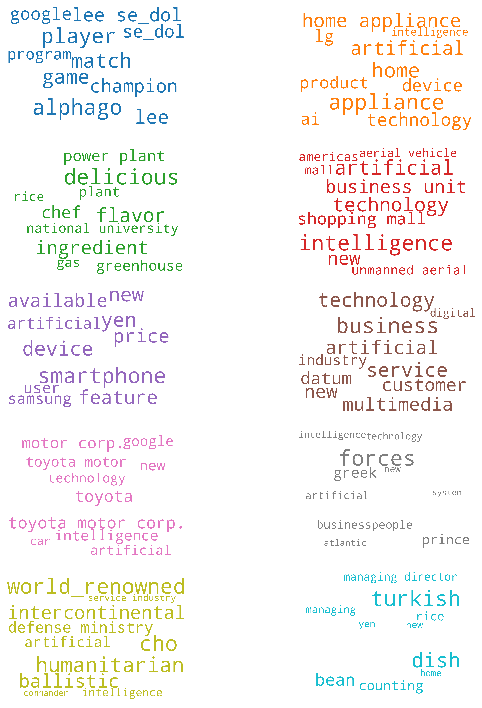

In [23]:
topics1 =topics[30:40]#does not plot more than 10, hence next ten , next ten iterate till no of topics
fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics1[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show();

Larger topics are more frequent in the corpus.
Topics closer together are more similar, topics further apart are less similar.
When you select a topic, you can see the most representative words for the selected topic. This measure can be a combination of how frequent or how discriminant the word is. You can adjust the weight of each property using the slider.
Hovering over a word will adjust the topic sizes according to how representative the word is for the topic.

In [24]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(LDModel, corpus, dictionary=LDModel.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.003532  0.078003       1        1  13.052670
11     0.087985 -0.055705       2        1   6.643148
35    -0.107919  0.024093       3        1   5.602922
4     -0.055543  0.092912       4        1   5.571925
41    -0.001592 -0.048391       5        1   4.598172
15    -0.000057  0.070425       6        1   3.693018
24    -0.015536 -0.028093       7        1   3.074391
34    -0.192121 -0.095119       8        1   3.042464
12    -0.060645 -0.031191       9        1   2.916853
58    -0.120541  0.008918      10        1   2.615136
27    -0.106904  0.099865      11        1   2.486982
3      0.102682  0.042369      12        1   2.388644
53     0.083919 -0.123739      13        1   2.302631
47    -0.005350  0.091456      14        1   2.247132
43     0.025973 -0.020075      15        1   2.025274
23     0.016882 -0.057594      16        1   2.023956
10    -0.028167 -0.012434      17        1   2.014649
9      0.065365  0.082432      18        1   1.911564
8      0.005106 -0.001732      19        1   1.744146
1      0.101951 -0.103398      20        1   1.671417
48     0.006389 -0.047163      21        1   1.667195
52     0.020116  0.011682      22        1   1.643258
57     0.107711  0.046258      23        1   1.639208
59     0.023858  0.105090      24        1   1.602059
50     0.064977  0.117601      25        1   1.599834
25    -0.058921  0.082498      26        1   1.489496
28     0.060137 -0.018212      27        1   1.468225
54     0.010071 -0.056561      28        1   1.450587
14     0.026250  0.159844      29        1   1.259081
5      0.010207 -0.060871      30        1   1.237975
49    -0.159906  0.004774      31        1   1.221102
36    -0.008583 -0.030822      32        1   1.199024
30     0.048524 -0.075362      33        1   1.142227
31    -0.163432 -0.074520      34        1   1.126504
42    -0.004897  0.113063      35        1   0.851789
6     -0.031744  0.001795      36        1   0.689306
46    -0.018065 -0.023025      37        1   0.577852
33    -0.052269 -0.020743      38        1   0.515488
17    -0.038459 -0.075939      39        1   0.512809
19     0.031493  0.012977      40        1   0.511955
51     0.074106 -0.073387      41        1   0.451554
56    -0.015501  0.078421      42        1   0.447649
32     0.020845 -0.008528      43        1   0.421675
45    -0.050870  0.048775      44        1   0.411891
22    -0.043453 -0.012495      45        1   0.376068
2      0.047885 -0.006349      46        1   0.336081
21     0.077909  0.023441      47        1   0.304208
40     0.033986 -0.012471      48        1   0.289263
7      0.056408 -0.043637      49        1   0.283979
26     0.024402  0.047343      50        1   0.279030
18    -0.126579 -0.055175      51        1   0.268323
55     0.074399 -0.089505      52        1   0.201968
39     0.002133  0.041993      53        1   0.191439
20     0.063501 -0.024800      54        1   0.148546
38     0.024346 -0.012296      55        1   0.127282
29     0.024064  0.070531      56        1   0.125865
0     -0.005293 -0.109416      57        1   0.104033
16     0.027423  0.004880      58        1   0.080511
37     0.046870 -0.009375      59        1   0.068312
44    -0.021995 -0.043315      60        1   0.050260, topic_info=    Category         Freq          Term        Total  loglift  logprob
8    Default  6038.000000    artificial  6038.000000  30.0000  30.0000
75   Default  5554.000000  intelligence  5554.000000  29.0000  29.0000
152  Default  4551.000000    technology  4551.000000  28.0000  28.0000
104  Default  4436.000000           new  4436.000000  27.0000  27.0000
685  Default  2906.000000            ai  2906.000000  26.0000  26.0000
..       ...          ...           ...          ...      ...      ...
685  Topic60     1.557802            ai  2906.842041   0.0642  -5.5974
139  Topic60     1.463461       service  

# 5. What is the Dominant topic and its percentage contribution in each document

In [25]:
df4=pd.read_csv('jap2.csv', encoding='utf8')
'''
typically only one of the topics is dominant in one doc. The below code extracts this dominant topic for each doc and 
shows the weight of the topic and the keywords in a nicely formatted output.

What is the Dominant topic and its percentage contribution in each document
format documents to get a datafrme including: Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 
'content', 'title'. then transform this to a df df_dominant_topic including
'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'title'
in the end, we'll be able to see which topics are dominat in the doxuments, will get the docs w highest 
topic % contribution, hence will be able to read them in detail.

'''
 
'''5.1 get dominant topics per each doc'''

def format_topics_docs(ldamodel=LDModel, corpus=corpus, texts=lms, titles=df4.Title):
    # Init output
    doc_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                doc_topics_df = doc_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    doc_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    title = pd.Series(titles)
    doc_topics_df = pd.concat([doc_topics_df, contents, title], axis=1)
    return(doc_topics_df)

df_topic_docs_keywords = format_topics_docs(ldamodel=LDModel, corpus=corpus, texts=df4.Content, titles= df4.Title)

"\ntypically only one of the topics is dominant in one doc. The below code extracts this dominant topic for each doc and \nshows the weight of the topic and the keywords in a nicely formatted output.\n\nWhat is the Dominant topic and its percentage contribution in each document\nformat documents to get a datafrme including: Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', \n'content', 'title'. then transform this to a df df_dominant_topic including\n'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'title'\nin the end, we'll be able to see which topics are dominat in the doxuments, will get the docs w highest \ntopic % contribution, hence will be able to read them in detail.\n\n"

'5.1 get dominant topics per each doc'

In [26]:
# Format
df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'title']

''' view texts  and dom tops for each doc'''
pd.set_option('display.max_colwidth', -1)
df_dominant_topic.loc[:5, ['Dominant_Topic', 'title']]

# Distribution of Dominant Topics in Each Document, no of docs with top i having as dom top 
dominant_topic_in_each_doc = df_dominant_topic.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()
# Distribution of Dominant Topics in Each Document, no of docs with top i having as dom top 

' view texts  and dom tops for each doc'

,Dominant_Topic,title
0,13.0,Will robots take your job? Quarter of US workers at risk
1,4.0,China bars millions from travel for 'social credit' offenses
2,48.0,How Google aims to simplify your life with AI
3,49.0,Google and Walmart team up to take on Amazon
4,15.0,Archbishop of Canterbury is accused of hypocrisy after slamming web giant Amazon for ‘leeching’ off taxpayers – as it emerges his Church holds a multi-million-pound stake in the retailer
5,3.0,"Robots could become CRIMINALS: Police may not be able to stop AI breaking the law, warn experts"


# 5.3 Distribution of Document Word Counts by Dominant Topic, is the topic in short or long docs?

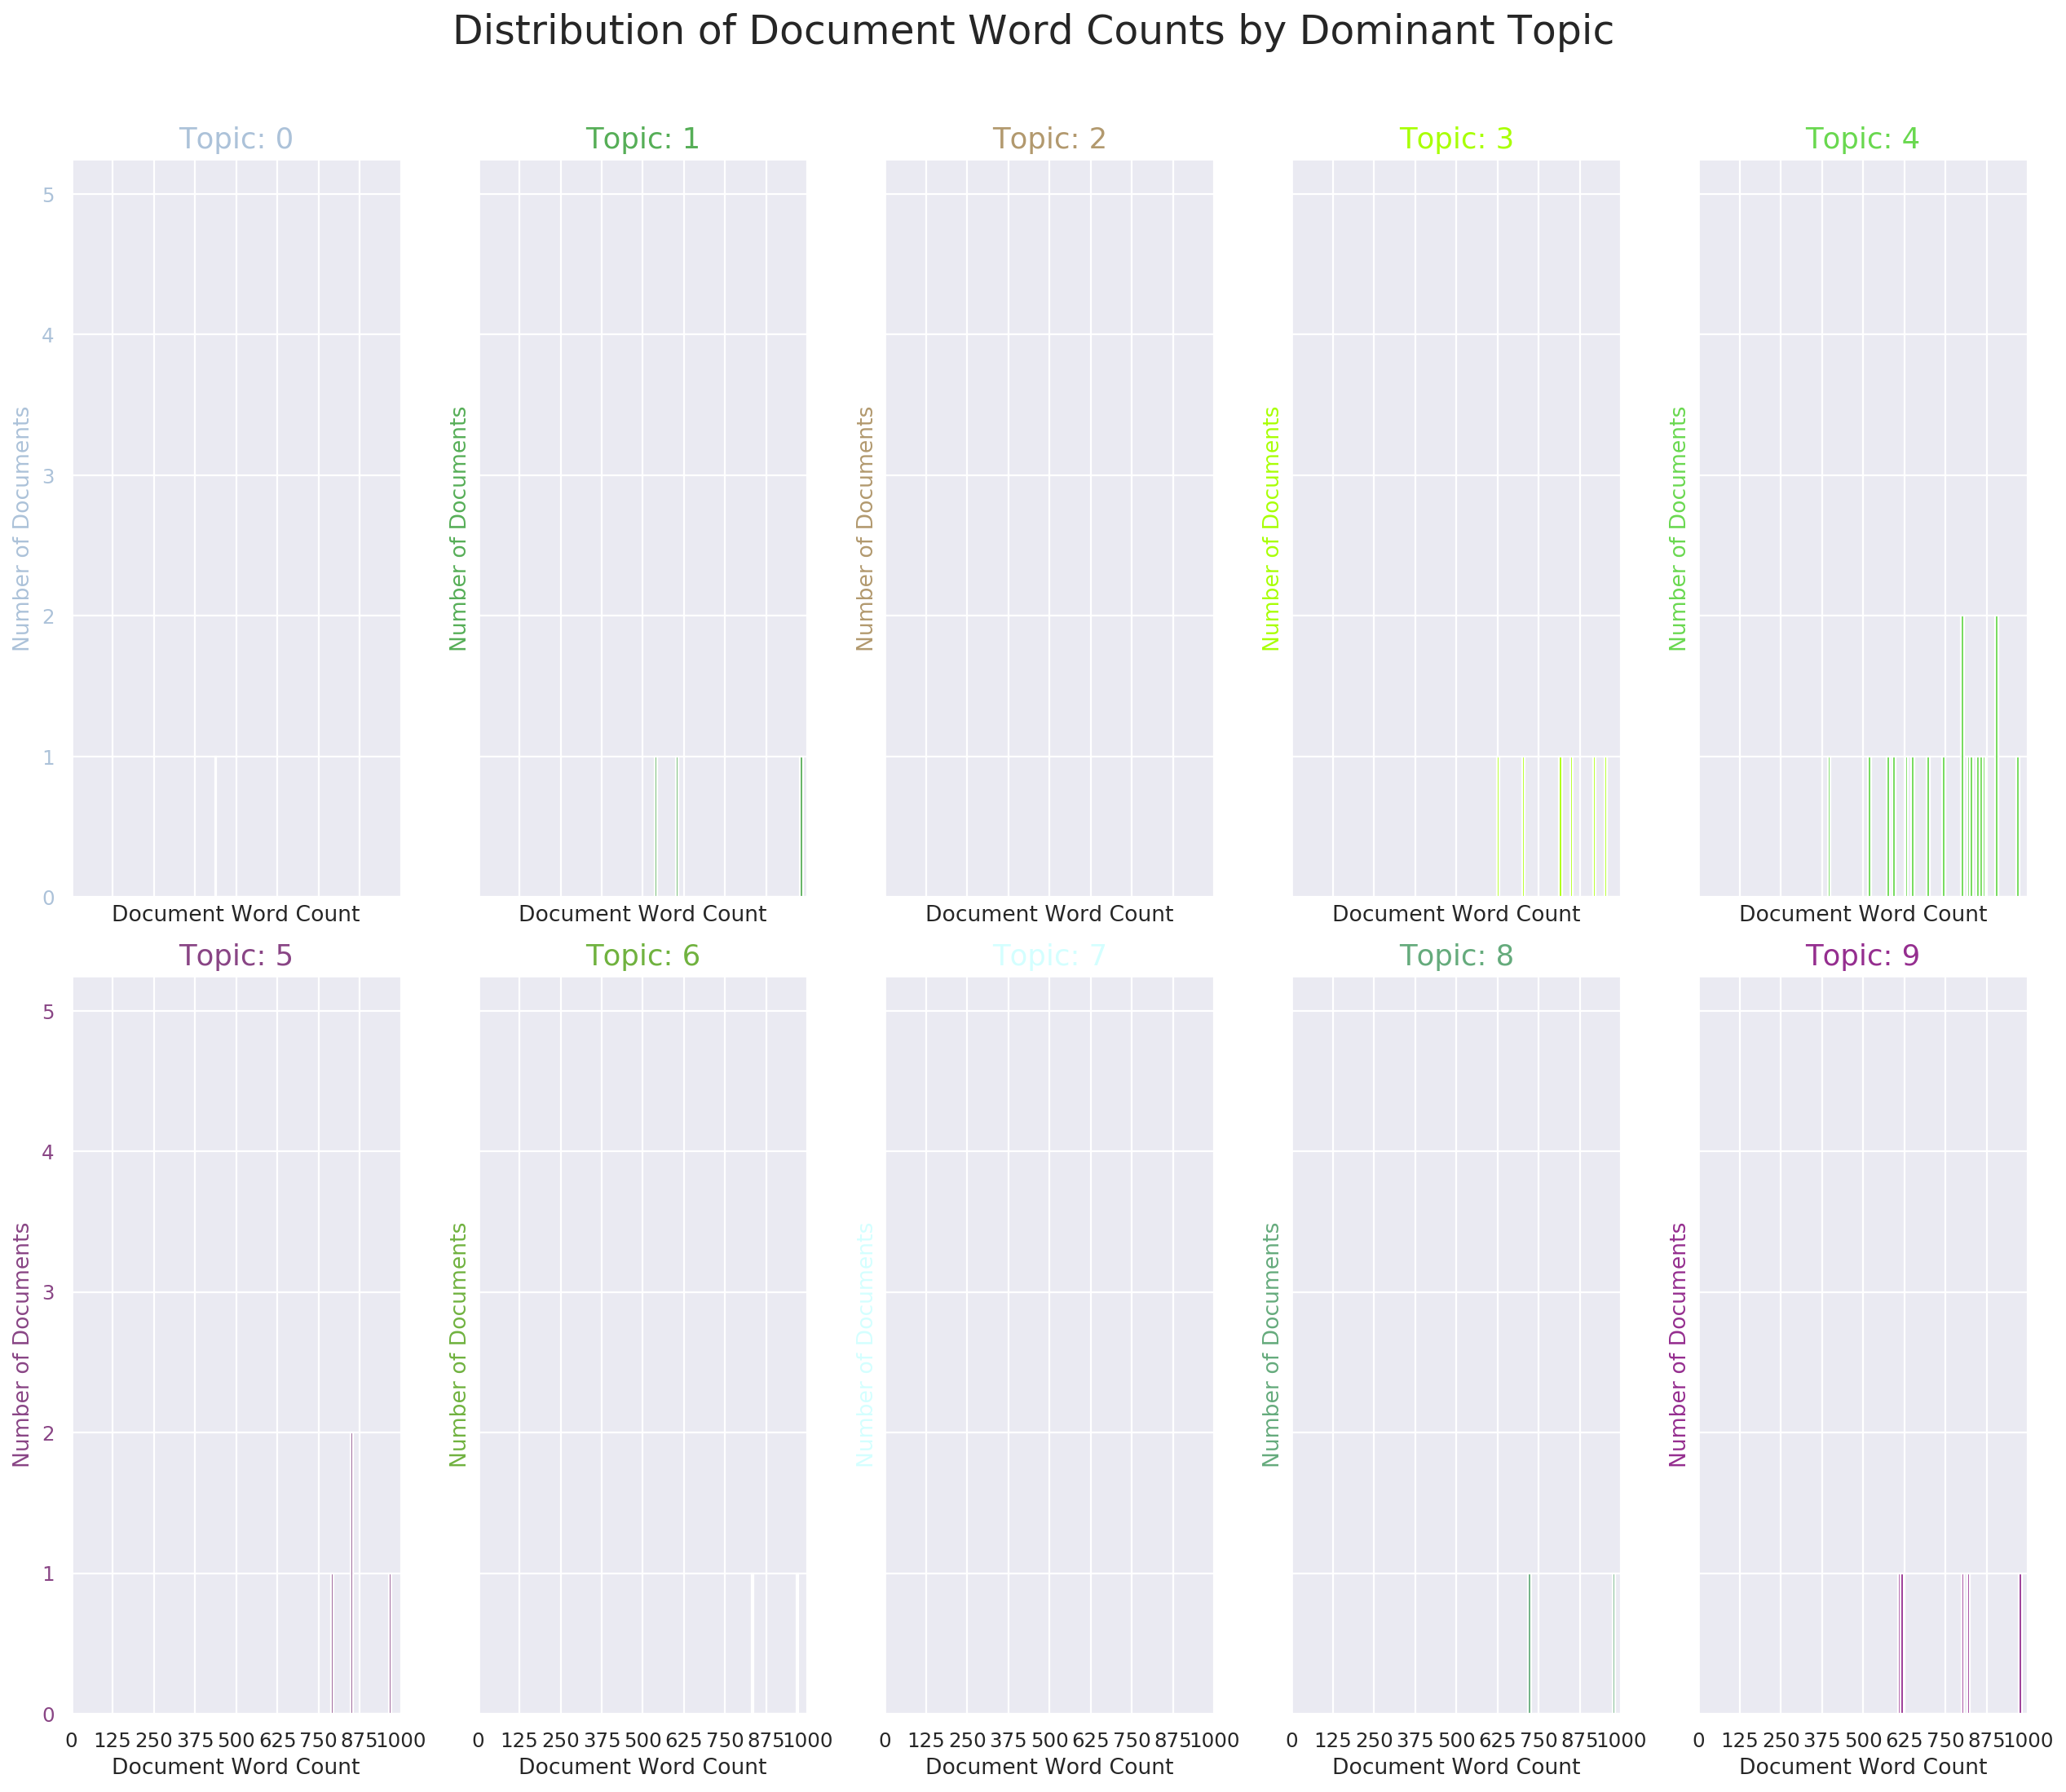

In [27]:
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
fig, axes = plt.subplots(2,5,figsize=(16,14), dpi=160, sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show();

# 5.4

What are the most discussed topics in the documents? distribution of no of docs to each topic?

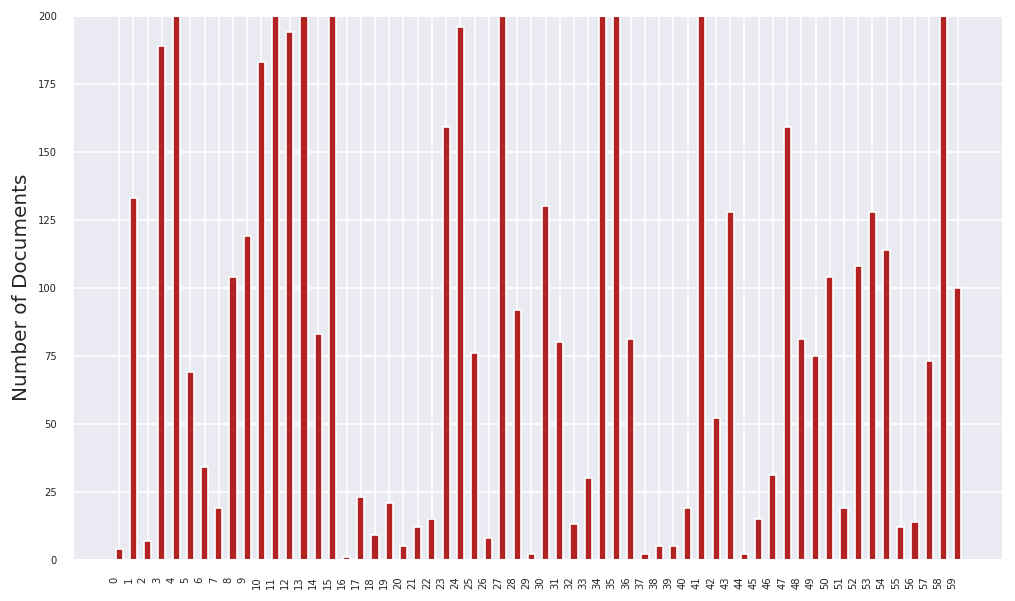

In [28]:
#Top 3 Keywords for each Topic, to see what the topics are abouut, as topi labels
topic_top3words = [(i, topic) for i, topics in LDModel.show_topics(formatted=False, num_topics=ntp) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg('.'.join)
df_top3words.reset_index(level=0,inplace=True)

fig, ax1 = plt.subplots(figsize=(10, 6), dpi=120)
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
#tick_formatter = ticker.FuncFormatter(lambda x, pos: df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
#ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 200)
ax1.tick_params(axis='both', which='major', labelsize=6, pad=4)
plt.xticks(rotation=90, ha='right')
plt.show();

In [29]:
df_top3words.reset_index(level=0,inplace=True)

In [30]:
df_top3words

,index,topic_id,words
0,0,0,tooth.multimedia.variant
1,1,1,robot.human.question
2,2,2,ice cream.pub.new
3,3,3,military.defense.weapon
4,4,4,technology.artificial.intelligence
5,5,5,intelligence.artificial.new
6,6,6,intelligence.artificial.mobile carrier
7,7,7,orbit.spacecraft.mars
8,8,8,artificial.intelligence.electric
9,9,9,court.intelligence.minister


# 5.5

Find the most representative 5 documents for each topic
you'll get: 'Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text", 'title', hence will be able see the top docs

In [31]:
# Group top 5 docs under each topic
doc_topics_sorteddf_mallet = pd.DataFrame()

doc_topics_outdf_grpd = df_topic_docs_keywords.groupby('Dominant_Topic')

for i, grp in doc_topics_outdf_grpd:
    doc_topics_sorteddf_mallet = pd.concat([doc_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False)], 
                                            axis=0)
# Reset Index    
doc_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
doc_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text", 'title']


In [32]:
tn=10#which topic docs you want to see?
cln ='Text' # title  "Keywords"   Text# what do you want to see?
hm = 5# how many docs do you want to see
slct = doc_topics_sorteddf_mallet.loc[doc_topics_sorteddf_mallet['Topic_Num'] == tn]

slct.loc[:, ["Topic_Perc_Contrib",cln]].head(hm)
x= slct.loc[:, ["Topic_Perc_Contrib",cln]].head(hm)

from gensim.summarization import summarize, keywords
for txt in x.Text:
    pprint(summarize(txt, ratio=.1))# word_count, ratio

Topic_Perc_Contrib  \
1106  0.8518               
1107  0.8251               
1108  0.8082               
1109  0.7927               
1110  0.7755               

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

('A deep learning artificial intelligence AI system has been developed to '
 'detect gastric cancers, and achieved over 90 percent accuracy in analysis of '
 'more than 2,000 endoscopic images in under a minute, a team made up of '
 'mostly Saitama and Tokyo_based researchers has announced in the journal '
 'Gastric Cancer.')
('Researchers trained a form of artificial intelligence or machine learning '
 'known as a deep learning convolutional neural network CNN to identify skin '
 'cancer by showing it more than 100,000 images of malignant melanomas the '
 'most lethal form of skin cancer , as well as benign moles or nevi .They '
 'compared its performance with that of 58 international dermatologists and '
 'found that the CNN missed fewer melanomas and misdiagnosed benign moles less '
 'often as malignant than the group of dermatologists.')
('A new study suggests that people who take a class of common medicines called '
 'anticholinergic drugs for several years may be more likely to d

'5.5 11. doc Chart Colored by Topic \n1. Sentence Chart Colored by Topic\nEach word in the document is representative of one of the all topics. Let’s color each word in the given documents \nby the topic id it is attributed to. NEEDS SOME IMPROVEMT VIUSAILZATION\n\nhttps://markroxor.github.io/gensim/static/notebooks/topic_methods.html\n'

     |████████████████████████████████| 11.1MB 4.7kB/s eta 0:00:02   |▎                               | 92kB 134kB/s eta 0:01:22     |█████████                       | 3.1MB 2.0MB/s eta 0:00:04     |█████████████                   | 4.5MB 421kB/s eta 0:00:16     |█████████████████████           | 7.2MB 92kB/s eta 0:00:42     |█████████████████████▏          | 7.3MB 92kB/s eta 0:00:41     |████████████████████████▍       | 8.5MB 150kB/s eta 0:00:18     |█████████████████████████▎      | 8.7MB 213kB/s eta 0:00:11     |███████████████████████████     | 9.3MB 216kB/s eta 0:00:09     |███████████████████████████▉    | 9.6MB 209kB/s eta 0:00:07     |██████████████████████████████  | 10.4MB 24kB/s eta 0:00:28     |██████████████████████████████▋ | 10.6MB 59kB/s eta 0:00:09
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.1.0-cp37-none-any.whl size=11074435 sha256=5a62e263ac17b88a28dc5bacaddfb59e17d388023b4cc111d7f1bc5837cc2dfc
  Stored in directory: /tmp/pip-ephem-wheel-cache-jqb

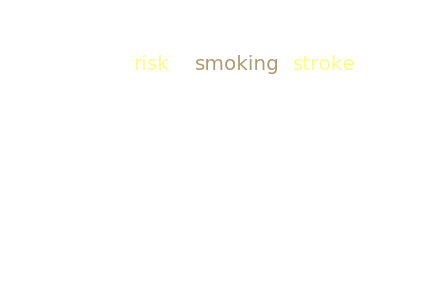

In [34]:
'''5.5 11. doc Chart Colored by Topic 
1. Sentence Chart Colored by Topic
Each word in the document is representative of one of the all topics. Let’s color each word in the given documents 
by the topic id it is attributed to. NEEDS SOME IMPROVEMT VIUSAILZATION

https://markroxor.github.io/gensim/static/notebooks/topic_methods.html
'''
!pip install spacy && python -m spacy download en
def color_words(model, doc):
    # make into bag of words
    doc = model.id2word.doc2bow(doc)
    # get word_topics
    doc_topics, word_topics, phi_values = model.get_document_topics(doc, per_word_topics=True)
    # color-topic matching
    colormap = np.array([color for name, color in mcolors.XKCD_COLORS.items()])
    x =list(range(0,ntp))
    y= colormap[0:ntp]
    topic_colors = dict(zip(x,y))
    # set up fig to plot
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    # a sort of hack to make sure the words are well spaced out.
    word_pos = 1/len(doc)
    
    # use matplotlib to plot words
    for word, topics in word_topics:
        ax.text(word_pos, 0.8, model.id2word[word],
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=20, color=topic_colors[topics[0]],  # choose just the most likely topic
                transform=ax.transAxes)
        word_pos += 0.2 # to move the word for the next iter

    ax.set_axis_off()
    plt.axis('off')
    plt.grid(b=None)
    plt.show()
    
text=df4.Title[257]
nl =spacy.load('en', disable=('vectors', 'textcat', "parser", "ner"))
doc = [w.lemma_ for w in nl(text) if not w.is_stop and  not w.is_punct and not w.like_num\
       and  w.text !='\n' ]
color_words(LDModel, doc)

In [35]:
''' manual ;labeling of topics
top_labels = {0: 'Statistics', 1:'Numerical Analysis', 2:'Online Learning', 3:'Deep Learning'}
'''

" manual ;labeling of topics\ntop_labels = {0: 'Statistics', 1:'Numerical Analysis', 2:'Online Learning', 3:'Deep Learning'}\n"

In [36]:
'''TSNE PLOT
https://shuaiw.github.io/2016/12/22/topic-modeling-and-tsne-visualzation.html

'''

def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document. i.e. topic_weights, gives a doc by topic matrix
    """
    topic_weights = lda_model.get_document_topics(document, minimum_probability=0)
    topic_weights = np.array(topic_weights)
    return topic_weights[:,1]


arr  = list(map(lambda doc:
                          document_to_lda_features(LDModel, doc),
                          corpus))

'TSNE PLOT\nhttps://shuaiw.github.io/2016/12/22/topic-modeling-and-tsne-visualzation.html\n\n'

In [37]:
arr = pd.DataFrame(arr).fillna(0)# topic weights
# Keep the well separated points (optional)
doc_top_mat=arr.values

# Dominant topic number in each doc
_lda_keys = list(np.argmax(doc_top_mat, axis=1))#topic numbers
num_example = len(doc_top_mat)
topic_summaries= df_top3words['words'].values

# a t-SNE model
# angle value close to 1 means sacrificing accuracy for speed
# pca initializtion usually leads to better results 
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.5, init='pca')
# 35-D -> 2-D
tsne_lda = tsne_model.fit_transform(doc_top_mat)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7621 samples in 0.015s...
[t-SNE] Computed neighbors for 7621 samples in 12.478s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7621
[t-SNE] Computed conditional probabilities for sample 2000 / 7621
[t-SNE] Computed conditional probabilities for sample 3000 / 7621
[t-SNE] Computed conditional probabilities for sample 4000 / 7621
[t-SNE] Computed conditional probabilities for sample 5000 / 7621
[t-SNE] Computed conditional probabilities for sample 6000 / 7621
[t-SNE] Computed conditional probabilities for sample 7000 / 7621
[t-SNE] Computed conditional probabilities for sample 7621 / 7621
[t-SNE] Mean sigma: 0.130597
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.042755
[t-SNE] KL divergence after 1000 iterations: 1.762967


In [38]:
import bokeh.plotting as bp
from bokeh.plotting import save
from bokeh.models import HoverTool

title = '35 LDA viz'
colormap = np.array([color for name, color in mcolors.XKCD_COLORS.items()])

plot_lda = bp.figure(plot_width=1400, plot_height=1100,
                     title=title,
                     tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

    
plot_lda.scatter(x=tsne_lda[:, 0], y=tsne_lda[:, 1],
                 color=colormap[_lda_keys][:num_example],
              )

topic_coord = np.empty((np.array(doc_top_mat).shape[1], 2)) * np.nan
for topic_num in _lda_keys:
  if not np.isnan(topic_coord).any():
    break
  topic_coord[topic_num] = tsne_lda[_lda_keys.index(topic_num)]

# plot crucial words
for i in range(np.array(doc_top_mat).shape[1]):
  plot_lda.text(topic_coord[i, 0], topic_coord[i, 1], [topic_summaries[i]])

output_file("foo.html")
show(plot_lda)

GlyphRenderer(id='1028', ...)

GlyphRenderer(id='1035', ...)

GlyphRenderer(id='1042', ...)

GlyphRenderer(id='1049', ...)

GlyphRenderer(id='1056', ...)

GlyphRenderer(id='1063', ...)

GlyphRenderer(id='1070', ...)

GlyphRenderer(id='1077', ...)

GlyphRenderer(id='1084', ...)

GlyphRenderer(id='1091', ...)

GlyphRenderer(id='1098', ...)

GlyphRenderer(id='1105', ...)

GlyphRenderer(id='1112', ...)

GlyphRenderer(id='1119', ...)

GlyphRenderer(id='1126', ...)

GlyphRenderer(id='1133', ...)

GlyphRenderer(id='1140', ...)

GlyphRenderer(id='1147', ...)

GlyphRenderer(id='1154', ...)

GlyphRenderer(id='1161', ...)

GlyphRenderer(id='1168', ...)

GlyphRenderer(id='1175', ...)

GlyphRenderer(id='1182', ...)

GlyphRenderer(id='1189', ...)

GlyphRenderer(id='1196', ...)

GlyphRenderer(id='1203', ...)

GlyphRenderer(id='1210', ...)

GlyphRenderer(id='1217', ...)

GlyphRenderer(id='1224', ...)

GlyphRenderer(id='1231', ...)

GlyphRenderer(id='1238', ...)

GlyphRenderer(id='1245', ...)

GlyphRenderer(id='1252', ...)

GlyphRenderer(id='1259', ...)

GlyphRenderer(id='1266', ...)

GlyphRenderer(id='1273', ...)

GlyphRenderer(id='1280', ...)

GlyphRenderer(id='1287', ...)

GlyphRenderer(id='1294', ...)

GlyphRenderer(id='1301', ...)

GlyphRenderer(id='1308', ...)

GlyphRenderer(id='1315', ...)

GlyphRenderer(id='1322', ...)

GlyphRenderer(id='1329', ...)

GlyphRenderer(id='1336', ...)

GlyphRenderer(id='1343', ...)

GlyphRenderer(id='1350', ...)

GlyphRenderer(id='1357', ...)

GlyphRenderer(id='1364', ...)

GlyphRenderer(id='1371', ...)

GlyphRenderer(id='1378', ...)

GlyphRenderer(id='1385', ...)

GlyphRenderer(id='1392', ...)

GlyphRenderer(id='1399', ...)

GlyphRenderer(id='1406', ...)

GlyphRenderer(id='1413', ...)

GlyphRenderer(id='1420', ...)

GlyphRenderer(id='1427', ...)

GlyphRenderer(id='1434', ...)

GlyphRenderer(id='1441', ...)

GlyphRenderer(id='1448', ...)

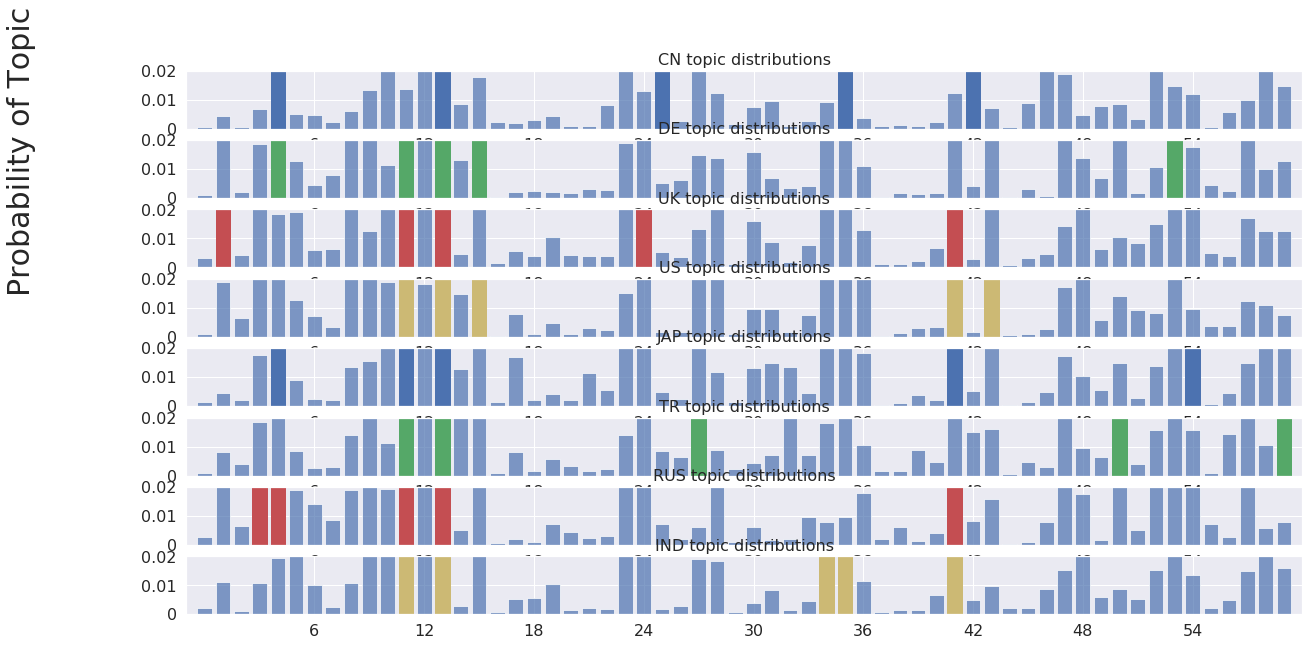

In [39]:
df4['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDModel, doc),
                                      corpus))
CN_topic_distribution = df4.loc[df4.country == 'cn', 'lda_features'].mean()
DE_topic_distribution = df4.loc[df4.country == 'ger', 'lda_features'].mean()
UK_topic_distribution = df4.loc[df4.country == 'uk', 'lda_features'].mean()
US_topic_distribution = df4.loc[df4.country == 'us', 'lda_features'].mean()
JAP_topic_distribution = df4.loc[df4.country == 'jap', 'lda_features'].mean()
TR_topic_distribution = df4.loc[df4.country == 'tr', 'lda_features'].mean()
RUS_topic_distribution = df4.loc[df4.country == 'rus', 'lda_features'].mean()
IND_topic_distribution = df4.loc[df4.country == 'ind', 'lda_features'].mean()

fig, [ax1,ax2,ax3, ax4, ax5, ax6, ax7, ax8] = plt.subplots(8,1,figsize=(20,10))

nr_top_bars = 5

ax1.set_title("CN topic distributions", fontsize=16)
ax2.set_title("DE topic distributions", fontsize=16)
ax3.set_title("UK topic distributions", fontsize=16)
ax4.set_title("US topic distributions", fontsize=16)
ax5.set_title("JAP topic distributions", fontsize=16)
ax6.set_title("TR topic distributions", fontsize=16)
ax7.set_title("RUS topic distributions", fontsize=16)
ax8.set_title("IND topic distributions", fontsize=16)

ax3.text(-10, 0.04, "Probability of Topic", fontsize=30, ha="center", va="center",
         rotation="vertical")

for ax, distribution, color in zip([ax1,ax2,ax3, ax4, ax5, ax6, ax7, ax8],
                                   [CN_topic_distribution,DE_topic_distribution,UK_topic_distribution, US_topic_distribution, JAP_topic_distribution,\
                                   TR_topic_distribution,RUS_topic_distribution,IND_topic_distribution],
                                   ['b','g','r', 'y','b','g','r', 'y']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, ntp)
    ax.set_xticks(range(int(ntp/10),ntp,int(ntp/10)))
    ax.set_xticklabels(range(int(ntp/10),ntp,int(ntp/10)), fontsize=16)
    ax.set_ylim(0,0.02)
    ax.set_yticks([0,0.01,0.02])
    ax.set_yticklabels([0,0.01,0.02], fontsize=16)

fig.tight_layout(h_pad=3.);

In [40]:
'''topic words per count'''
def get_topic_top_words(lda_model, topic_id, nr_top_words=10):
    """ Returns the top words for topic_id from lda_model.
    """
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words


for country, distribution in zip(['CN', 'DE', 'UK', 'US','JAP', 'TR', 'RUS', 'IND'], [CN_topic_distribution,DE_topic_distribution,UK_topic_distribution, US_topic_distribution, JAP_topic_distribution,\
                                   TR_topic_distribution,RUS_topic_distribution,IND_topic_distribution]):
    print("Looking up top words from top topics from {}.".format(country))
    for x in sorted(np.argsort(distribution)[-10:]):
        top_words = get_topic_top_words(LDModel, x)
        print("For topic {}, : {}.".format(x, ", ".join(top_words)))
    print("")

'topic words per count'

Looking up top words from top topics from CN.
For topic 4, : technology, artificial, intelligence, new, president, china, business, chinese, global, research.
For topic 10, : patient, medical, treatment, doctor, disease, health, artificial, intelligence, system, clinical.
For topic 12, : technology, intelligence, artificial, new, system, ai, keyword, machine, datum, copyright.
For topic 13, : artificial, intelligence, technology, development, industry, new, global, government, business, sector.
For topic 23, : human, artificial, intelligence, brain, system, function, technology, computer, ai, development.
For topic 25, : china, intelligence, artificial, chinese, new, local, development, province, technology, world economy.
For topic 35, : business, technology, service, artificial, new, multimedia, customer, datum, industry, digital.
For topic 42, : central news agency, development, taipei, artificial, event, international, central news, taiwan, city, local.
For topic 52, : artificial, 